**4장 - 모델 훈련**

***이 노트북은 4장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다***

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다. (파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다.) 사이킷런 버전이 0.20이상인지도 확인합니다.

In [20]:
# 파이썬 >= 3.5 필수
import sys
assert sys.version_info >= (3,5)

# 사이킷런 >= 0.20 필수
import sklearn
assert sklearn.__version__ >= '0.20'

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해 
np.random.seed(42)

# 깔끔한 그래프 출력을 위해 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 선형 회귀

In [6]:
import numpy as np
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

그림저장: generated_data_plot


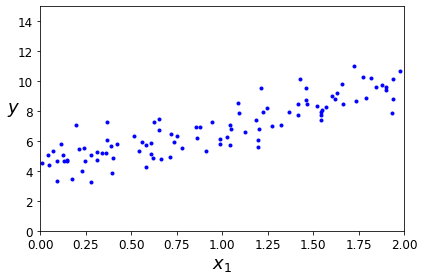

In [21]:
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

**식 4-4: 정규 방정식**

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

In [27]:
X_b = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [28]:
theta_best

array([[4.21509616],
       [2.77011339]])

$\hat{y} = \mathbf{X} \hat{\theta}$

In [51]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

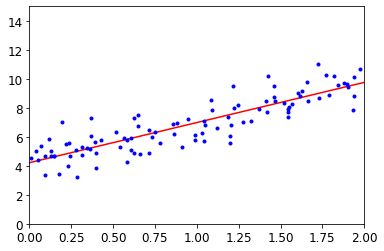

In [33]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

책에 있는 그림은 범례와 축 레이블이 있는 그래프입니다:

그림저장: linear_model_predictions_plpt


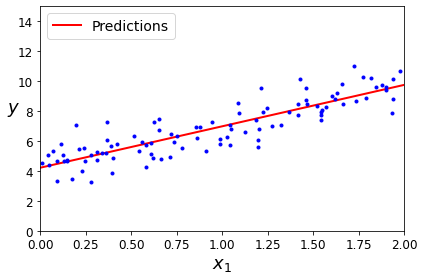

In [34]:
plt.plot(X_new, y_predict, 'r-', linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0,2,0,15])
save_fig("linear_model_predictions_plot")
plt.show()

In [35]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [36]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

```LinearRegression``` 클래스는 ```scipy.linalg.lstsq()``` 함수 ("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있습니다. 

In [37]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

이 함수는 $\mathbf{X}^+y$을 계산합니다. $\mathbf{X}^+$는 $\mathbf{X}$의 유사역행렬(pseudoinverse)입니다(Moore-Penrose 유사역행렬입니다.) ```np.linalg.pinv()```을 사용해서 유사역행렬을 직접 계산할 수 있습니다. 

$\hat{\theta} = \mathbf{X}^{-1} \hat{y}$

In [39]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# 경사 하강법 

## 배치 경사 하강법

**식 4-6: 비용 함수의 그레이디언트 벡터**

$\dfrac{\partial}{\partial \boldsymbol{\theta}}
\text{MSE}(\boldsymbol{\theta})
= \dfrac{2}{m} \mathbf{X}^{T}(\mathbf{X} \boldsymbol{\theta} - y)
$

**식 4-7 : 경사 하강법의 스탭**

$
\boldsymbol{\theta}^{\text{(next step)}}
= \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE} (\boldsymbol{\theta})
$

In [40]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 랜덤 초기화 

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [41]:
theta

array([[4.21509616],
       [2.77011339]])

In [42]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

In [44]:
theta_path_bfd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
        plt.xlabel("$x_1$", fontsize=18)
        plt.axis([0,2,0,15])
        plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림저장: gradient_descent_plot


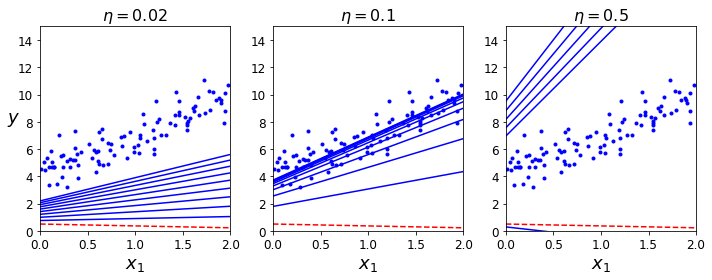

In [47]:
np.random.seed(42)
theta = np.random.randn(2,1) # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path = theta_path_bfd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

## 확률적 경사 하강법

In [52]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림저장: sgd_plot


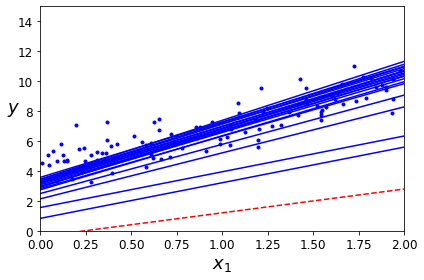

In [63]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = 'b-' if i > 0 else 'r--'
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
        
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,2,0,15])
save_fig("sgd_plot")
plt.show()

In [64]:
theta

array([[4.18280714],
       [2.77787149]])

In [68]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [69]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

## 미니배치 경사 하강법

In [73]:
theta_path_mgd = []

n_iterations = 50 
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1) # 랜덤 초기화

t0, t1 = 200,1000
def learning_schedule(t):
    return t0/(t+t1)

t = 0 
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [74]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [76]:
theta_path_bfd = np.array(theta_path_bfd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림저장: gradient_descent_paths_plot


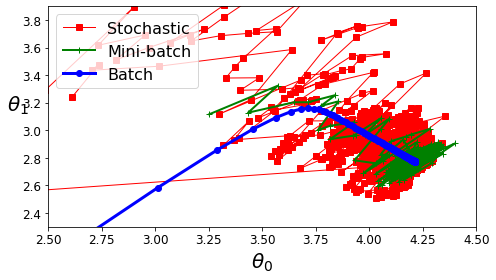

In [91]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:,0], theta_path_sgd[:, 1], 'r-s', linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:, 1], 'g-+', linewidth=2, label="Mini-batch")
plt.plot(theta_path_bfd[:,0], theta_path_bfd[:, 1], 'b-o', linewidth=3, label="Batch")
plt.legend(loc='upper left', fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20, rotation=0)
plt.axis([2.5,4.5,2.3,3.9])
save_fig('gradient_descent_paths_plot')
plt.show()

# 다항 회귀

In [92]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [116]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

그림저장: quadratic_data_plot


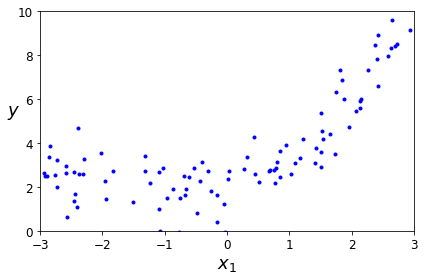

In [117]:
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.axis([-3,3,0,10])
save_fig("quadratic_data_plot")
plt.show()

In [118]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.72919168])

In [119]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.01873554]), array([[1.04271531, 0.50866711]]))

그림저장: quadratic_predictions_plot


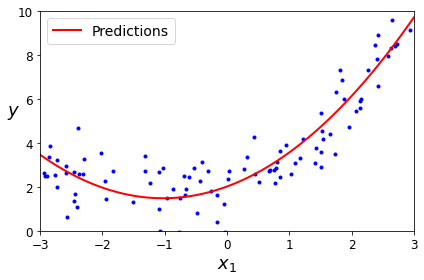

In [120]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

그림저장: high_degree_polynomials_plot


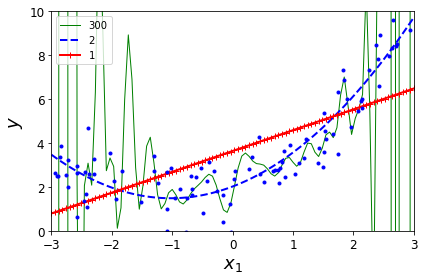

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (('g-',1,300),('b--',2,2),('r-+',2,1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ('poly_features', polybig_features),
        ('std_scaler', std_scaler),
        ('lin_reg', lin_reg)
    ])
    polynomial_regression.fit(X,y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)
    
plt.plot(X, y, 'b.', linewidth=3)
plt.legend(loc='upper left')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18)
plt.axis([-3,3,0,10])
save_fig("high_degree_polynomials_plot")
plt.show()

# 학습 곡선

In [124]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)+1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val[:m])
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val[:m], y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

그림저장: underfitting_learning_curves_plot


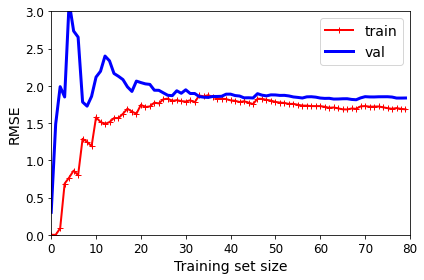

In [128]:
lin_reg = LinearRegression()
plot_learning_curve(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

그림저장: learning_curves_plot


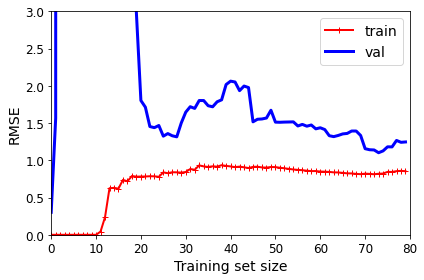

In [130]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curve(polynomial_regression, X, y)
plt.axis([0,80,0,3])
save_fig("learning_curves_plot")
plt.show()

# 규제가 있는 선형 모델 

## 릿지회귀

In [131]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m,1)
y = 1 + 0.5 * X + np.random.randn(m,1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100,1)

**식 4-8:릿지 회귀의 비용 함수**

$J(\boldsymbol{\theta}) = \text(MSE)(\boldsymbol{\theta}) + a \frac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2$

In [134]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [135]:
ridge_reg = Ridge(alpha=1, solver='sag', random_state=42)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

그림저장: ridge_regression_plot


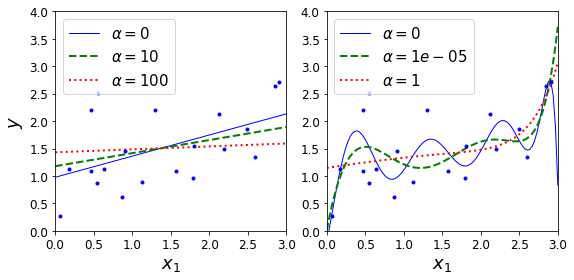

In [144]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('regul_reg', model),
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, 'b.', linewidth=3)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0,3,0,4])
    
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0,10,100), random_state=42)
plt.ylabel("$y$", fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0,10**-5,1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

**노트**: 향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.21 기본값인 ```max_iter=1000```과 ```tol=1e-3```으로 지정합니다,

In [154]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

## 라쏘 회귀

C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


그림저장: lasso_regression_plot


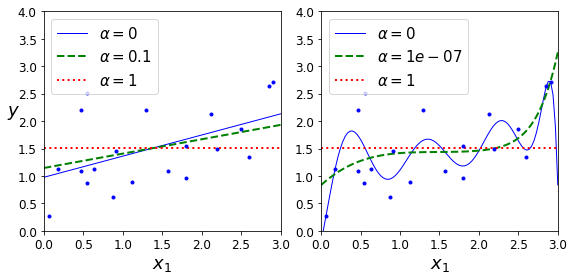

In [156]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [157]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## 엘라스틱넷

**식4-12: 엘라스틱넷 비용 함수**

$J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta})+r\alpha
\sum\limits_{i=1}^{n}\left|\boldsymbol{\theta}_i\right| + \frac{1-r}{2}\alpha\sum\limits_{i=1}^{n}\boldsymbol{\theta}_i^2
$

In [158]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## 조기종료

In [160]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m ,1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [165]:
from copy import deepcopy

poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty,warm_start=True,
                      penalty=None, learning_rate='constant', eta0=0.0005,
                      random_state=42)

minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # 중지된 곳에서 다시 시작합니다.
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그래프를 그립니다:

그림저장: early_stopping_plot


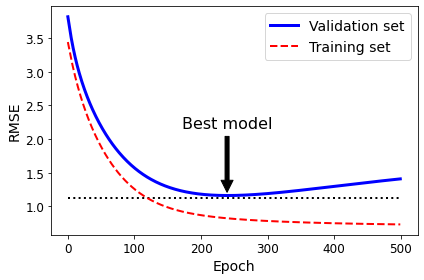

In [185]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate="constant",
                      eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    
best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',             
             xy = (best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse+1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16
            )

best_val_rmse -= 0.03 # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], 'k:', linewidth=2)
plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), 'r--', linewidth=2, label="Training set")
plt.legend(loc='upper right', fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [187]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

# 로지스틱 회귀 

## 결정 경계

In [189]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [190]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [191]:
X = iris['data'][:,3:] # 꽃잎 너비
y = (iris['target'] == 2).astype(int) # Iris virginica이면 1 아니면 0

In [192]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs', random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

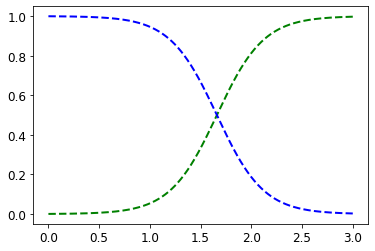

In [193]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:,1], 'g--', linewidth=2, label='Iris virginica')
plt.plot(X_new, y_proba[:,0], 'b--', linewidth=2, label="Not Iris virginica")

In [198]:
decision_boundary = X_new[y_proba[:,1] >= 0.5]

In [200]:
decision_boundary[0]

array([1.66066066])

# 소프트맥스 회귀

그림저장: logistic_regression_contour_plot


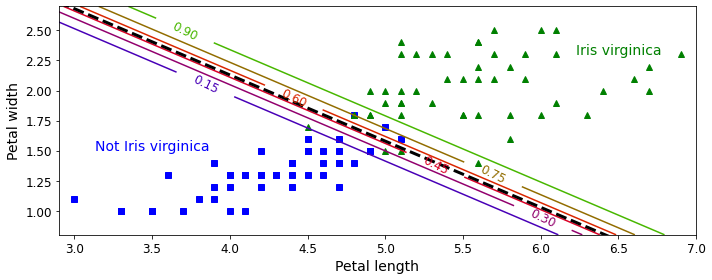

In [320]:
from sklearn.linear_model import LogisticRegression

X = iris['data'][:, (2,3)] # petal length, petal width
y = (iris['target'] == 2).astype(int)

log_reg = LogisticRegression(solver='lbfgs', C= 10**10, random_state=42)
log_reg.fit(X,y)

x0, x1 = np.meshgrid(
    np.linspace(2.9, 7, 500).reshape(-1,1),
    np.linspace(0.8, 2.7, 200).reshape(-1,1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10,4))
plt.plot(X[y==0, 0], X[y==0, 1], 'bs')
plt.plot(X[y==1, 0], X[y==1, 1], 'g^')

zz = y_proba[:,1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([2.9,7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, 'k--', linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color='b', ha='center')
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color='g', ha='center')
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9,7,0.8,2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

In [322]:
X = iris['data'][:,(2,3)] # 꽃잎 길이, 꽃잎 너비
y = iris['target']

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(multi_class='multinomial', random_state=42)

그림저장: softmax_regression_contour_plot


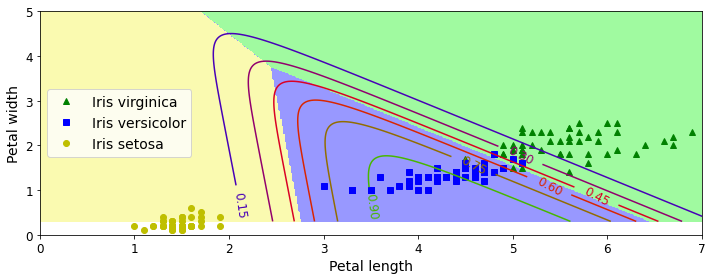

In [331]:
x0, x1 = np.meshgrid(
    np.linspace(0,8,500).reshape(-1,1),
    np.linspace(0.3,5,200).reshape(-1,1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:,1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10,4))
plt.plot(X[y==2, 0], X[y==2, 1], 'g^', label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], 'bs', label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], 'yo', label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [333]:
softmax_reg.predict([[5,2]])

array([2])

In [334]:
softmax_reg.predict_proba([[5,2]])

array([[2.43559894e-04, 2.14859516e-01, 7.84896924e-01]])